In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

## Section 1: Metadata

In [2]:
## Load metadata.
metadata = read_csv(os.path.join('..','prolific','data','metadata.csv'))

#### 1.1 Study Metrics

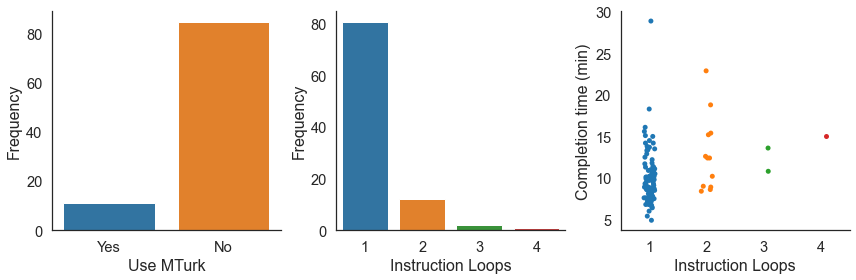

In [3]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## Plot platform use.
sns.countplot(metadata.mturk, order=['Yes', 'No'], ax=axes[0])
axes[0].set(xlabel='Use MTurk', ylabel='Frequency')

## Plot instructions loops.
sns.countplot(metadata.n_loops, ax=axes[1])
axes[1].set(xlabel='Instruction Loops', ylabel='Frequency')

## Plot participation time.
sns.stripplot('n_loops', 'minutes', data=metadata, palette=sns.color_palette(), ax=axes[2])
axes[2].set(xlabel='Instruction Loops', ylabel='Completion time (min)')

sns.despine()
plt.tight_layout()

## Section 2: Self-Report Data

In [4]:
## Load survey data.
surveys = read_csv(os.path.join('..','prolific','data','surveys.csv'))

#### 2.1 Infrequency Items
Following Huang et al. (2015) and Ophir et al. (2019), we included 3 infrequency items in our surveys (1 per survey). These are items with only one correct or highly probable answer. Previous research suggests that a zero-tolerance scoring of infrequency items is too severe ([Kim et al., 2018](http://dx.doi.org/10.3758/s13428-017-0964-9)), thus we will not reject based on a single improbable answer.

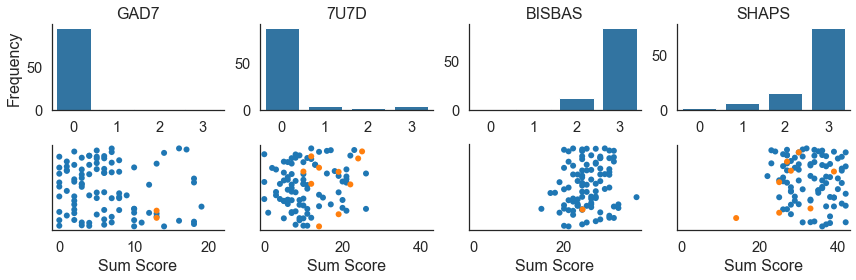

In [6]:
## Initialize canvas.
fig, axes = plt.subplots(2,4,figsize=(12,4))

## Define metadata.
prefixes = ['gad7','7u7d','bisbas','shaps']
orders = [np.arange(4), np.arange(4), np.arange(4), np.arange(4)] 
flags = [(1,2,3),(1,2,3),(0,1),(0,1)]

## Iteratively plot.
for i, (prefix, order, flag) in enumerate(zip(prefixes, orders, flags)):
    
    ## Extract surveys.
    items = surveys.filter(regex=f'{prefix}-q').values
    
    ## Separate infrequency item from others.
    infreq = items[:,-1]
    items = items[:,:-1]
    
    ## Compute sum scores.
    sum_scores = items.sum(axis=1)
    
    ## Plot responses on infrequency items.
    sns.countplot(infreq, order=order, color='#1f77b4', ax=axes[0,i])
    axes[0,i].set(ylabel='', title=prefix.upper())
    if not i: axes[0,i].set_ylabel('Frequency')
        
    ## Plot distribution of scores.
    sns.stripplot(sum_scores[~np.in1d(infreq, flag)], color='#1f77b4', size=6, ax=axes[1,i])
    sns.stripplot(sum_scores[np.in1d(infreq, flag)], color='#ff7f0e', size=6, ax=axes[1,i])
    axes[1,i].set(xlabel='Sum Score', xlim=(-1,items.shape[-1] * order[-1]+1))
    
sns.despine()
plt.tight_layout()

#### 2.2 Reading Times 
Following Ophir et al. (2019), we set a a reading-speed threshold of 10 words per second. This amounts to approximately 1s per GAD-7 item (8s total), 2.5s per 7-up-7-down item (37.5s total), 1s per BIS/BAS item (13s total), and 1s per SHAPS items (15s total).



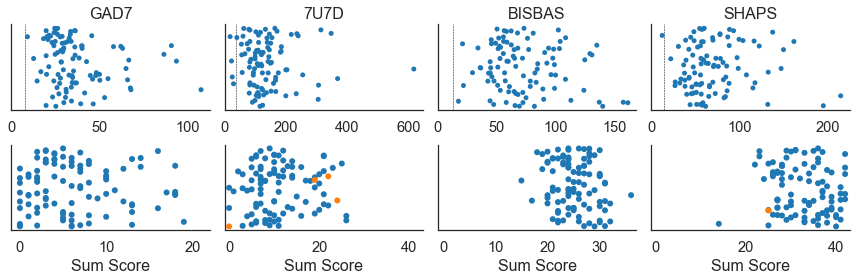

In [7]:
## Initialize canvas.
fig, axes = plt.subplots(2,4,figsize=(12,4))

## Define metadata.
prefixes = ['gad7','7u7d','bisbas','shaps']
orders = [np.arange(4), np.arange(4), np.arange(4), np.arange(4)] 
totals = [8, 37.5, 13, 15]

## Iteratively plot.
for i, (prefix, order, total) in enumerate(zip(prefixes, orders, totals)):
    
    ## Extract surveys.
    items = surveys.filter(regex=f'{prefix}-q').values[:,:-1] 
    rt = surveys.filter(regex=f'{prefix}-rt').values.flatten()
    
    ## Compute sum scores.
    sum_scores = items.sum(axis=1)
    
    ## Plot responses on infrequency items.
    sns.stripplot(rt, color='#1f77b4', ax=axes[0,i])
    axes[0,i].axvline(total, lw=0.5, linestyle='--', color='k')
    axes[0,i].set(xlim=(0), ylabel='', title=prefix.upper())
        
    ## Plot distribution of scores.
    sns.stripplot(sum_scores[rt > total], color='#1f77b4', size=6, ax=axes[1,i])
    sns.stripplot(sum_scores[rt < total], color='#ff7f0e', size=6, ax=axes[1,i])
    axes[1,i].set(xlabel='Sum Score', xlim=(-1,items.shape[-1] * order[-1]+1))
    
sns.despine()
plt.tight_layout()

## Section 3: Behavioral Data

In [8]:
## Load survey data.
data = read_csv(os.path.join('..','prolific','data','data.csv'))

#### 3.1 Accuracy

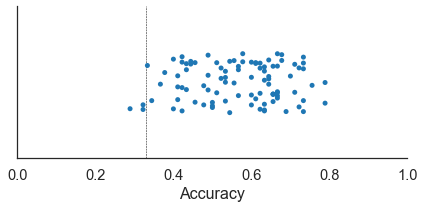

In [9]:
## Compute within-subject accuracy.
gb = data.groupby('subject').accuracy.mean()
test = gb.copy()

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,3))

## Plot scores.
sns.stripplot(gb, ax=ax)
ax.axvline(0.33, lw=0.5, linestyle='--', color='k')
ax.set(xlim=(0,1), xlabel='Accuracy', ylim=(-0.25,0.25))

sns.despine()
plt.tight_layout()

#### 3.2 Win-Stay Lose-Shift

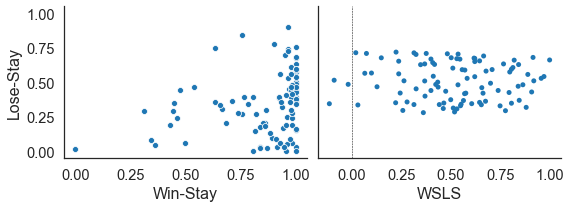

In [10]:
## Define WSLS regression.
def wsls_regression(df):
    df = df.dropna().copy()
    X = df[['intercept','prev_outcome']].dropna().values    
    y = df['stay']
    return np.linalg.lstsq(X,y,rcond=-1)[0][-1]

## Define previous outcome.
f = lambda x: np.roll(x, 1)
data['prev_outcome'] = data.groupby('subject').outcome.transform(f)
data.loc[data.trial==1,'prev_outcome'] = np.nan

## Define stay choices.
f = lambda x: (x == np.roll(x,1)).astype(int)
data['stay'] = data.groupby('subject').choice.transform(f)
data.loc[data.trial==1,'stay'] = np.nan

## Define intercept.
data['intercept'] = 1

## Compute pivot table.
pivot = data.groupby(['subject','prev_outcome']).stay.mean().reset_index()
pivot = pivot.pivot_table('stay','subject','prev_outcome')

## Compute WSLS coefficient.
coef = data.groupby('subject').apply(wsls_regression)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(8,3))

## Plot WSLS rates.
sns.scatterplot(pivot[1], pivot[0], ax=axes[0])
axes[0].set(xlim=(-0.05,1.05), xlabel='Win-Stay', ylim=(-0.05,1.05), ylabel='Lose-Stay')

## Plot coefficients.
sns.stripplot(coef, ax=axes[1])
axes[1].axvline(0, lw=0.5, linestyle='--', color='k')
axes[1].set(xlabel='WSLS', ylim=(-0.25,0.25))

sns.despine()
plt.tight_layout()